## Upload data

In [216]:
import sagemaker
from sagemaker import get_execution_role
import numpy as np
from PIL import Image
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [217]:
data_dir = "/home/ec2-user/SageMaker/efs/data"
data_bucket = sagemaker_session.upload_data(path=os.path.join(data_dir,'brain-segmentation'), key_prefix='brain-segmentation')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208


In [177]:
sample_train_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "sample-train"), distribution='FullyReplicated')
sample_validation_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "sample-validation"), distribution='FullyReplicated')
train_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "train"), distribution='FullyReplicated')
validation_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "validation"), distribution='FullyReplicated')
distributed_train_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "distributed-training"), distribution='ShardedByS3Key')

## Test Input

In [178]:
test_brain = np.array(Image.open("test.png"))[np.newaxis,np.newaxis,:]

In [179]:
test_brain.shape

(1, 1, 176, 208)

## Local Mode

In [ ]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker-python-sdk/mxnet_gluon_mnist/setup.sh

In [ ]:
!/bin/bash ./setup.sh

In [218]:
local_unet_job = 'DEMO-local-unet-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [219]:
from sagemaker.mxnet import MXNet

local_estimator = MXNet(entry_point='brain_segmentation.py',
                            base_job_name = local_unet_job,
                            source_dir = 'source_dir',
                            role=role,
                            train_instance_count=1, 
                            train_instance_type='local',
                            hyperparameters={
                                'learning_rate': 1E-3 * 16,
                                'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                'network':'unet',
                                'batch_size': 8,
                                'epochs':1
                        })

In [220]:
local_estimator.fit({'train':sample_train_s3, 'test':sample_validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-local-unet-job-2018-06-15-00-54-03-2018-06-15-00-54-04-016


Attaching to tmpbhi8mg_algo-1-4BKIN_1
algo-1-4BKIN_1  | 2018-06-15 00:54:06,316 INFO - root - running container entrypoint
algo-1-4BKIN_1  | 2018-06-15 00:54:06,317 INFO - root - starting train task
algo-1-4BKIN_1  | 2018-06-15 00:54:06,325 INFO - container_support.training - Training starting
algo-1-4BKIN_1  | 2018-06-15 00:54:06,827 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'test': {u'ContentType': u'application/octet-stream'}, u'train': {u'ContentType': u'application/octet-stream'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1-4BKIN', u'hosts': [u'algo-1-4BKIN']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'h

In [221]:
local_unet_endpoint = 'DEMO-local-unet-endpoint-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [222]:
local_predictor = local_estimator.deploy(initial_instance_count=1, instance_type='local',
                                         endpoint_name=local_unet_endpoint)

INFO:sagemaker:Creating model with name: DEMO-local-unet-job-2018-06-15-00-54-03-2018-06-15-00-54-04-016
INFO:sagemaker:Creating endpoint with name DEMO-local-unet-endpoint-2018-06-15-01-18-37


!

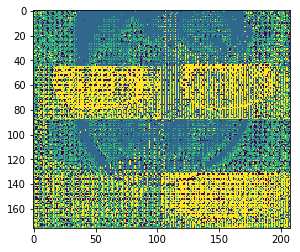

In [223]:
response = local_predictor.predict(test_brain.tolist())
output = np.argmax(np.array(response), axis=(1))[0].astype(np.uint8)
plt.imshow(output)

## UNet - 1 Machine

In [224]:
unet_single_machine_job = 'DEMO-unet-single-machine-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [225]:
unet_single_machine_estimator = MXNet(entry_point='brain_segmentation.py',
                                                base_job_name = unet_single_machine_job,
                                                source_dir = 'source_dir',
                                                role=role,
                                                train_instance_count=1, 
                                                train_instance_type='ml.p3.2xlarge',
                                                hyperparameters={
                                                    'learning_rate': 1E-3,
                                                    'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                                    'network':'unet',
                                                    'batch_size': 32,
                                            })

In [226]:
unet_single_machine_estimator.fit({'train':train_s3, 'test':validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-unet-single-machine-job-2018-06-15-2018-06-15-01-18-49-169


..........................
2018-06-15 01:22:58,302 INFO - root - running container entrypoint
2018-06-15 01:22:58,302 INFO - root - starting train task
2018-06-15 01:22:58,322 INFO - container_support.training - Training starting
2018-06-15 01:23:00,666 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'o

2018-06-15 01:28:18,063 INFO - root - Epoch[19] Train-avg_dice_coef_metric=0.123044
2018-06-15 01:28:18,063 INFO - root - Epoch[19] Time cost=13.228
2018-06-15 01:28:20,454 INFO - root - Epoch[19] Validation-avg_dice_coef_metric=0.123405
2018-06-15 01:28:33,613 INFO - root - Epoch[20] Train-avg_dice_coef_metric=0.121005
2018-06-15 01:28:33,613 INFO - root - Epoch[20] Time cost=13.159
2018-06-15 01:28:35,846 INFO - root - Epoch[20] Validation-avg_dice_coef_metric=0.129375
2018-06-15 01:28:48,912 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.118891
2018-06-15 01:28:48,912 INFO - root - Epoch[21] Time cost=13.066
2018-06-15 01:28:51,171 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.123663
2018-06-15 01:29:04,227 INFO - root - Epoch[22] Train-avg_dice_coef_metric=0.117368
2018-06-15 01:29:04,227 INFO - root - Epoch[22] Time cost=13.056
2018-06-15 01:29:06,519 INFO - root - Epoch[22] Validation-avg_dice_coef_metric=0.127605
2018-06-15 01:29:19,694 INFO - root - Epoch[23] 

2018-06-15 01:36:16,699 INFO - root - Epoch[50] Train-avg_dice_coef_metric=0.104233
2018-06-15 01:36:16,699 INFO - root - Epoch[50] Time cost=13.126
2018-06-15 01:36:19,002 INFO - root - Epoch[50] Validation-avg_dice_coef_metric=0.177537
2018-06-15 01:36:32,274 INFO - root - Epoch[51] Train-avg_dice_coef_metric=0.103856
2018-06-15 01:36:32,274 INFO - root - Epoch[51] Time cost=13.272
2018-06-15 01:36:34,575 INFO - root - Epoch[51] Validation-avg_dice_coef_metric=0.114425
2018-06-15 01:36:47,758 INFO - root - Epoch[52] Train-avg_dice_coef_metric=0.108807
2018-06-15 01:36:47,759 INFO - root - Epoch[52] Time cost=13.184
2018-06-15 01:36:50,088 INFO - root - Epoch[52] Validation-avg_dice_coef_metric=0.129261
2018-06-15 01:37:03,186 INFO - root - Epoch[53] Train-avg_dice_coef_metric=0.106679
2018-06-15 01:37:03,187 INFO - root - Epoch[53] Time cost=13.098
2018-06-15 01:37:05,559 INFO - root - Epoch[53] Validation-avg_dice_coef_metric=0.112265
2018-06-15 01:37:18,647 INFO - root - Epoch[54] 

2018-06-15 01:44:16,072 INFO - root - Epoch[81] Train-avg_dice_coef_metric=0.086479
2018-06-15 01:44:16,072 INFO - root - Epoch[81] Time cost=13.086
2018-06-15 01:44:18,338 INFO - root - Epoch[81] Validation-avg_dice_coef_metric=0.110583
2018-06-15 01:44:31,446 INFO - root - Epoch[82] Train-avg_dice_coef_metric=0.086853
2018-06-15 01:44:31,446 INFO - root - Epoch[82] Time cost=13.108
2018-06-15 01:44:33,773 INFO - root - Epoch[82] Validation-avg_dice_coef_metric=0.105434
2018-06-15 01:44:47,167 INFO - root - Epoch[83] Train-avg_dice_coef_metric=0.087956
2018-06-15 01:44:47,167 INFO - root - Epoch[83] Time cost=13.394
2018-06-15 01:44:49,496 INFO - root - Epoch[83] Validation-avg_dice_coef_metric=0.102309
2018-06-15 01:45:02,704 INFO - root - Epoch[84] Train-avg_dice_coef_metric=0.086039
2018-06-15 01:45:02,704 INFO - root - Epoch[84] Time cost=13.208
2018-06-15 01:45:04,953 INFO - root - Epoch[84] Validation-avg_dice_coef_metric=0.108731
2018-06-15 01:45:18,377 INFO - root - Epoch[85] 

## UNET - Distributed (SYNCHRONOUS)

In [19]:
unet_distributed_job = 'DEMO-unet-distributed-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [20]:
unet_distributed_estimator = MXNet(entry_point='brain_segmentation.py',
                                   base_job_name = unet_distributed_job,
                                    source_dir = 'source_dir',
                                    role=role,
                                    train_instance_count=2, 
                                    train_instance_type='ml.p3.2xlarge',
                                    hyperparameters={
                                        'epochs': 50,
                                        'learning_rate': 1E-3,
                                        'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                        'network':'unet',
                                        'batch_size': 32,
                        })

In [21]:
unet_distributed_estimator.fit({'train':distributed_train_s3,
                            'test':validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-unet-distributed-job-2018-06-03-18-2018-06-03-18-05-57-843


.........................
2018-06-03 18:09:56,888 INFO - root - running container entrypoint
2018-06-03 18:09:56,889 INFO - root - starting train task
2018-06-03 18:09:56,909 INFO - container_support.training - Training starting
2018-06-03 18:09:59,179 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'ShardedByS3Key'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-2', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1', u'algo-2']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': u'/opt/ml/output/

2018-06-03 18:11:02,227 INFO - root - Epoch[4] Train-avg_dice_coef_metric=0.348321
2018-06-03 18:11:02,227 INFO - root - Epoch[4] Time cost=8.300
2018-06-03 18:11:02,045 INFO - root - Epoch[4] Train-avg_dice_coef_metric=0.349021
2018-06-03 18:11:02,045 INFO - root - Epoch[4] Time cost=8.331
2018-06-03 18:11:04,495 INFO - root - Epoch[4] Validation-avg_dice_coef_metric=0.343391
2018-06-03 18:11:04,664 INFO - root - Epoch[4] Validation-avg_dice_coef_metric=0.362441
2018-06-03 18:11:12,841 INFO - root - Epoch[5] Train-avg_dice_coef_metric=0.342326
2018-06-03 18:11:12,841 INFO - root - Epoch[5] Time cost=8.177
2018-06-03 18:11:12,870 INFO - root - Epoch[5] Train-avg_dice_coef_metric=0.340643
2018-06-03 18:11:12,871 INFO - root - Epoch[5] Time cost=8.375
2018-06-03 18:11:15,405 INFO - root - Epoch[5] Validation-avg_dice_coef_metric=0.348739
2018-06-03 18:11:15,406 INFO - root - Epoch[5] Validation-avg_dice_coef_metric=0.332649
2018-06-03 18:11:23,835 INFO - root - Epoch[6] Train-avg_dice_co

2018-06-03 18:13:55,841 INFO - root - Epoch[20] Train-avg_dice_coef_metric=0.303067
2018-06-03 18:13:55,841 INFO - root - Epoch[20] Time cost=8.478
2018-06-03 18:13:55,884 INFO - root - Epoch[20] Train-avg_dice_coef_metric=0.299484
2018-06-03 18:13:55,884 INFO - root - Epoch[20] Time cost=8.316
2018-06-03 18:13:58,383 INFO - root - Epoch[20] Validation-avg_dice_coef_metric=0.320477
2018-06-03 18:13:58,350 INFO - root - Epoch[20] Validation-avg_dice_coef_metric=0.305211
2018-06-03 18:14:06,577 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.299738
2018-06-03 18:14:06,578 INFO - root - Epoch[21] Time cost=8.194
2018-06-03 18:14:06,508 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.299941
2018-06-03 18:14:06,508 INFO - root - Epoch[21] Time cost=8.158
2018-06-03 18:14:08,994 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.310469
2018-06-03 18:14:09,093 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.320817
2018-06-03 18:14:17,502 INFO - root - Epoch[22] Trai

2018-06-03 18:16:49,257 INFO - root - Epoch[36] Train-avg_dice_coef_metric=0.251868
2018-06-03 18:16:49,257 INFO - root - Epoch[36] Time cost=8.349
2018-06-03 18:16:50,482 INFO - root - Epoch[36] Train-avg_dice_coef_metric=0.262335
2018-06-03 18:16:50,483 INFO - root - Epoch[36] Time cost=8.487
2018-06-03 18:16:51,822 INFO - root - Epoch[36] Validation-avg_dice_coef_metric=0.245293
2018-06-03 18:16:52,985 INFO - root - Epoch[36] Validation-avg_dice_coef_metric=0.278764
2018-06-03 18:17:00,245 INFO - root - Epoch[37] Train-avg_dice_coef_metric=0.243355
2018-06-03 18:17:00,246 INFO - root - Epoch[37] Time cost=8.424
2018-06-03 18:17:02,834 INFO - root - Epoch[37] Validation-avg_dice_coef_metric=0.268945
2018-06-03 18:17:01,234 INFO - root - Epoch[37] Train-avg_dice_coef_metric=0.261679
2018-06-03 18:17:01,234 INFO - root - Epoch[37] Time cost=8.249
2018-06-03 18:17:03,792 INFO - root - Epoch[37] Validation-avg_dice_coef_metric=0.293890
2018-06-03 18:17:11,663 INFO - root - Epoch[38] Trai

## Inference Endpoints

### Default Endpoint

In [230]:
unet_endpoint = 'DEMO-unet-endpoint-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [ ]:
unet_predictor = unet_single_machine_estimator.deploy(instance_type='ml.c5.xlarge', initial_instance_count=1,
                                                     endpoint_name=unet_endpoint)

INFO:sagemaker:Creating model with name: DEMO-unet-single-machine-job-2018-06-15-2018-06-15-01-18-49-169
INFO:sagemaker:Creating endpoint with name DEMO-unet-endpoint-2018-06-15-02-37-46


-------------------------------------------------

In [236]:
response = unet_predictor.predict(test_brain.tolist())

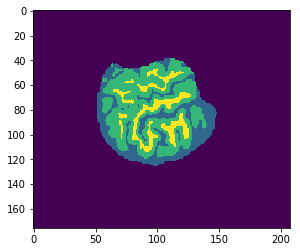

In [237]:
output = np.argmax(np.array(response), axis=(1))[0].astype(np.uint8)
plt.imshow(output)

In [235]:
4

4

### S3 Endpoint

In [493]:
unet_s3_endpoint = 'DEMO-unet-s3-endpoint-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [494]:
unet_single_machine_estimator.entry_point = "brain_segmentation_s3_transform.py"

In [495]:
unet_s3_predictor = unet_single_machine_estimator.deploy(instance_type='ml.c5.xlarge', initial_instance_count=1,
                                                     endpoint_name=unet_s3_endpoint)

INFO:sagemaker:Creating model with name: DEMO-unet-single-machine-job-2018-05-31-2018-05-31-20-08-46-514
INFO:sagemaker:Creating endpoint with name DEMO-unet-s3-endpoint-2018-06-02-03-58-46


---------------------------------------------------------------!

In [497]:
response = unet_s3_predictor.predict([request_body])

In [498]:
s3.download_file(Bucket=response['bucket'], Key=response['prefix'], Filename = "result.png")

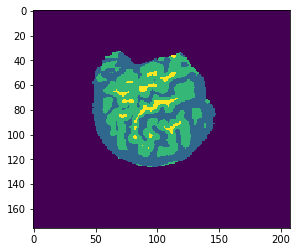

In [500]:
plt.imshow(np.array(Image.open("result.png")))

## ENet - 1 Machine

In [227]:
enet_single_machine_job = 'DEMO-enet-single-machine-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [228]:
enet_single_machine_estimator = MXNet(entry_point='brain_segmentation.py',
                                                base_job_name = enet_single_machine_job,
                                                source_dir = 'source_dir',
                                                role=role,
                                                train_instance_count=1, 
                                                train_instance_type='ml.p3.2xlarge',
                                                hyperparameters={
                                                    'learning_rate': 1E-3,
                                                    'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                                    'network':'enet',
                                                    'batch_size': 32,
                                            })

In [229]:
enet_single_machine_estimator.fit({'train':train_s3, 'test':validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-enet-single-machine-job-2018-06-15-2018-06-15-01-49-51-697


....................................
2018-06-15 01:55:43,888 INFO - root - running container entrypoint
2018-06-15 01:55:43,889 INFO - root - starting train task
2018-06-15 01:55:43,909 INFO - container_support.training - Training starting
2018-06-15 01:55:44,847 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/

2018-06-15 01:59:52,046 INFO - root - Epoch[19] Train-avg_dice_coef_metric=0.172250
2018-06-15 01:59:52,046 INFO - root - Epoch[19] Time cost=10.080
2018-06-15 01:59:54,065 INFO - root - Epoch[19] Validation-avg_dice_coef_metric=0.180918
2018-06-15 02:00:04,293 INFO - root - Epoch[20] Train-avg_dice_coef_metric=0.172102
2018-06-15 02:00:04,293 INFO - root - Epoch[20] Time cost=10.228
2018-06-15 02:00:06,240 INFO - root - Epoch[20] Validation-avg_dice_coef_metric=0.170995
2018-06-15 02:00:16,329 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.171932
2018-06-15 02:00:16,330 INFO - root - Epoch[21] Time cost=10.090
2018-06-15 02:00:18,260 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.183940
2018-06-15 02:00:28,119 INFO - root - Epoch[22] Train-avg_dice_coef_metric=0.163925
2018-06-15 02:00:28,119 INFO - root - Epoch[22] Time cost=9.859
2018-06-15 02:00:30,075 INFO - root - Epoch[22] Validation-avg_dice_coef_metric=0.170168
2018-06-15 02:00:40,256 INFO - root - Epoch[23] T

2018-06-15 02:06:04,615 INFO - root - Epoch[50] Train-avg_dice_coef_metric=0.130713
2018-06-15 02:06:04,616 INFO - root - Epoch[50] Time cost=10.069
2018-06-15 02:06:06,639 INFO - root - Epoch[50] Validation-avg_dice_coef_metric=0.134765
2018-06-15 02:06:16,917 INFO - root - Epoch[51] Train-avg_dice_coef_metric=0.131437
2018-06-15 02:06:16,917 INFO - root - Epoch[51] Time cost=10.278
2018-06-15 02:06:18,856 INFO - root - Epoch[51] Validation-avg_dice_coef_metric=0.134026
2018-06-15 02:06:28,816 INFO - root - Epoch[52] Train-avg_dice_coef_metric=0.125851
2018-06-15 02:06:28,816 INFO - root - Epoch[52] Time cost=9.960
2018-06-15 02:06:30,825 INFO - root - Epoch[52] Validation-avg_dice_coef_metric=0.138076
2018-06-15 02:06:40,728 INFO - root - Epoch[53] Train-avg_dice_coef_metric=0.125798
2018-06-15 02:06:40,728 INFO - root - Epoch[53] Time cost=9.902
2018-06-15 02:06:42,736 INFO - root - Epoch[53] Validation-avg_dice_coef_metric=0.155527
2018-06-15 02:06:52,690 INFO - root - Epoch[54] Tr

2018-06-15 02:12:19,431 INFO - root - Epoch[81] Train-avg_dice_coef_metric=0.117714
2018-06-15 02:12:19,431 INFO - root - Epoch[81] Time cost=9.982
2018-06-15 02:12:21,432 INFO - root - Epoch[81] Validation-avg_dice_coef_metric=0.129787
2018-06-15 02:12:31,584 INFO - root - Epoch[82] Train-avg_dice_coef_metric=0.117315
2018-06-15 02:12:31,584 INFO - root - Epoch[82] Time cost=10.152
2018-06-15 02:12:33,674 INFO - root - Epoch[82] Validation-avg_dice_coef_metric=0.127229
2018-06-15 02:12:44,003 INFO - root - Epoch[83] Train-avg_dice_coef_metric=0.113855
2018-06-15 02:12:44,004 INFO - root - Epoch[83] Time cost=10.330
2018-06-15 02:12:46,085 INFO - root - Epoch[83] Validation-avg_dice_coef_metric=0.127801
2018-06-15 02:12:56,113 INFO - root - Epoch[84] Train-avg_dice_coef_metric=0.114203
2018-06-15 02:12:56,113 INFO - root - Epoch[84] Time cost=10.028
2018-06-15 02:12:58,085 INFO - root - Epoch[84] Validation-avg_dice_coef_metric=0.125369
2018-06-15 02:13:08,271 INFO - root - Epoch[85] T

## mxnet 0.11

In [147]:
enet_eleven_job = 'DEMO-enet-eleven-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [148]:
enet_eleven_estimator = MXNet(entry_point='brain_segmentation.py',
                                                base_job_name = enet_eleven_job,
                                                source_dir = 'source_dir',
                                                role=role,
                                                train_instance_count=1, 
                                                train_instance_type='ml.p3.2xlarge',
                                                hyperparameters={
                                                    'learning_rate': 1E-3,
                                                    'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                                    'network':'enet',
                                                    'batch_size': 32,
                                            })

In [149]:
region = sagemaker_session.boto_session.region_name
enet_eleven_estimator.train_image = lambda:'780728360657.dkr.ecr.{}.amazonaws.com/sagemaker-mxnet-py2-gpu:1.0'.format(region)

In [150]:
enet_eleven_estimator.fit({'train':train_s3, 'test':validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-enet-eleven-job-2018-06-04-04-49-0-2018-06-04-04-49-07-097


.......................
executing startup script (first run)
2018-06-04 04:52:51,585 INFO - root - running container entrypoint
2018-06-04 04:52:51,585 INFO - root - starting train task
2018-06-04 04:52:52,675 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '

2018-06-04 04:57:10,913 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.304270
2018-06-04 04:57:10,913 INFO - root - Epoch[21] Time cost=8.789
2018-06-04 04:57:13,229 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.310643
2018-06-04 04:57:22,073 INFO - root - Epoch[22] Train-avg_dice_coef_metric=0.299768
2018-06-04 04:57:22,073 INFO - root - Epoch[22] Time cost=8.844
2018-06-04 04:57:24,374 INFO - root - Epoch[22] Validation-avg_dice_coef_metric=0.305673
2018-06-04 04:57:33,400 INFO - root - Epoch[23] Train-avg_dice_coef_metric=0.298148
2018-06-04 04:57:33,401 INFO - root - Epoch[23] Time cost=9.027
2018-06-04 04:57:35,684 INFO - root - Epoch[23] Validation-avg_dice_coef_metric=0.298992
2018-06-04 04:57:44,567 INFO - root - Epoch[24] Train-avg_dice_coef_metric=0.295296
2018-06-04 04:57:44,567 INFO - root - Epoch[24] Time cost=8.883
2018-06-04 04:57:46,862 INFO - root - Epoch[24] Validation-avg_dice_coef_metric=0.312386
2018-06-04 04:57:55,638 INFO - root - Epoch[25] Trai

2018-06-04 05:03:12,053 INFO - root - Epoch[53] Train-avg_dice_coef_metric=0.244655
2018-06-04 05:03:12,053 INFO - root - Epoch[53] Time cost=8.995
2018-06-04 05:03:14,326 INFO - root - Epoch[53] Validation-avg_dice_coef_metric=0.290085
2018-06-04 05:03:23,379 INFO - root - Epoch[54] Train-avg_dice_coef_metric=0.244724
2018-06-04 05:03:23,380 INFO - root - Epoch[54] Time cost=9.053
2018-06-04 05:03:25,666 INFO - root - Epoch[54] Validation-avg_dice_coef_metric=0.249492
2018-06-04 05:03:34,700 INFO - root - Epoch[55] Train-avg_dice_coef_metric=0.250986
2018-06-04 05:03:34,700 INFO - root - Epoch[55] Time cost=9.034
2018-06-04 05:03:36,989 INFO - root - Epoch[55] Validation-avg_dice_coef_metric=0.266141
2018-06-04 05:03:45,843 INFO - root - Epoch[56] Train-avg_dice_coef_metric=0.244764
2018-06-04 05:03:45,843 INFO - root - Epoch[56] Time cost=8.854
2018-06-04 05:03:48,126 INFO - root - Epoch[56] Validation-avg_dice_coef_metric=0.270541
2018-06-04 05:03:56,985 INFO - root - Epoch[57] Trai

2018-06-04 05:09:12,550 INFO - root - Epoch[85] Train-avg_dice_coef_metric=0.218253
2018-06-04 05:09:12,550 INFO - root - Epoch[85] Time cost=9.048
2018-06-04 05:09:14,865 INFO - root - Epoch[85] Validation-avg_dice_coef_metric=0.233243
2018-06-04 05:09:23,809 INFO - root - Epoch[86] Train-avg_dice_coef_metric=0.216462
2018-06-04 05:09:23,810 INFO - root - Epoch[86] Time cost=8.945
2018-06-04 05:09:26,107 INFO - root - Epoch[86] Validation-avg_dice_coef_metric=0.227813
2018-06-04 05:09:35,035 INFO - root - Epoch[87] Train-avg_dice_coef_metric=0.211800
2018-06-04 05:09:35,035 INFO - root - Epoch[87] Time cost=8.928
2018-06-04 05:09:37,323 INFO - root - Epoch[87] Validation-avg_dice_coef_metric=0.223888
2018-06-04 05:09:46,275 INFO - root - Epoch[88] Train-avg_dice_coef_metric=0.214226
2018-06-04 05:09:46,275 INFO - root - Epoch[88] Time cost=8.953
2018-06-04 05:09:48,610 INFO - root - Epoch[88] Validation-avg_dice_coef_metric=0.244663
2018-06-04 05:09:57,613 INFO - root - Epoch[89] Trai

In [151]:
enet_eleven_estimator.model_data

u's3://sagemaker-us-east-1-288000045208/DEMO-enet-eleven-job-2018-06-04-04-49-0-2018-06-04-04-49-07-097/output/model.tar.gz'

## Greengrass

* Follow instructions to set up ggc on rpi. 
* Then follow ML instructions, put MXNet in device.
* Replace with your own model path from above
* Replace zip package with one I will provide HERE
* Continue instructions
* Choose "Sagemaker model" instead doing ML resource selection
* Continue steps to Deploy
* add boot commands